In [1]:
using Plots; immerse()
default(size=(500,300), leg=false)

# creates x/y vectors which can define a grid in a zig-zag pattern
function gridxy(lim, n::Int)
    xs = linspace(lim..., n)
    xypairs = vec([(x,y) for x in vcat(xs,reverse(xs)), y in xs])
    Plots.unzip(xypairs)
end

gridxy (generic function with 1 method)

# The problem... can we classify the functions?

In [2]:
# these are the functions we want to classify
scalar = 5  # larger is harder... start with 3
f1(x) = 0.6sin(scalar * x) + 0.1
f2(x) = f1(x) - 0.2

# our target function is ∈ {-1,1}
target(f) = f == f1 ? 1.0 : -1.0

target (generic function with 1 method)

# On to the fun...

[Plots.jl] Initializing backend: immerse

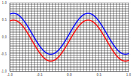

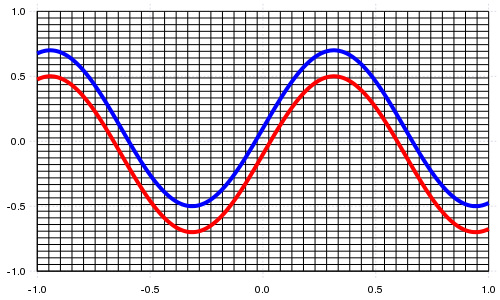

In [3]:
# pick the plotting limits
lim = (-1,1)
funcs = [f1, f2]
n = 40
gridx, gridy = gridxy(lim, n)
default(xlim = lim, ylim = lim)

function initialize_plot(funcs, lim, gridx, gridy; kw...)
    # show the grid
    plot([gridx gridy], [gridy gridx], c=:black, kw...)

    # show the funcs
    plot!(funcs, lim..., l=(4,[:blue :red]))
end

# kick off an animation... we can save frames whenever we want, lets save the starting frame
function initialize_animation()
    anim = Animation()
    frame(anim)
    anim
end

# lets see what we're dealing with...
p = initialize_plot(funcs, lim, gridx, gridy)

# That looks tricky... lets build a neural net!

In [4]:
using OnlineAI
net = buildTanhClassificationNet(
    2,    # number of inputs
    1,    # number of outputs
    [2], # hidden layers structure
#     params = NetParams(gradientModel = SGDModel(η=1e-5))
# params = NetParams(gradientModel = AdadeltaModel(η=1e-3, ρ=0.99))
params = NetParams(gradientModel = AdagradModel(η=1e-1))
)

# take x matrix and convert to the first layer's activation
function activateHidden(net, x)
    @assert net.layers[end].nin == 2
    proj = zeros(nrows(x), 2)
    for i in 1:nrows(x)
        data = row(x,i)
        for layer in net.layers[1:end-1]
            OnlineAI.forward!(layer, data, false)
            data = layer.a
        end
        row!(proj, i, data)
    end
    vec(proj[:,1]), vec(proj[:,2])
end    

INFO: Recompiling stale cache file /home/tom/.julia/lib/v0.4/OnlineStats.ji for module OnlineStats.


  0.312941 seconds (2.08 M allocations: 156.080 MB, 3.92% gc time)



maxabs(β - coef(o)) for

glm:      NaN
sgd:      NaN
proxgrad: 0.7831256793099914
rda:      1.1312508343813983


INFO: Recompiling stale cache file /home/tom/.julia/lib/v0.4/OnlineAI.ji for module OnlineAI.


activateHidden (generic function with 1 method)

# Update our model and the visualization

In [5]:
p = initialize_plot(funcs, lim, gridx, gridy)
anim = initialize_animation()
gui()

progressviz = track_progress(net, fields=[:x,:Σ,:a], size=(800,800), m=2, w=0);

  likely near In[5]:3


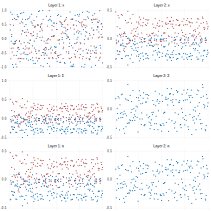

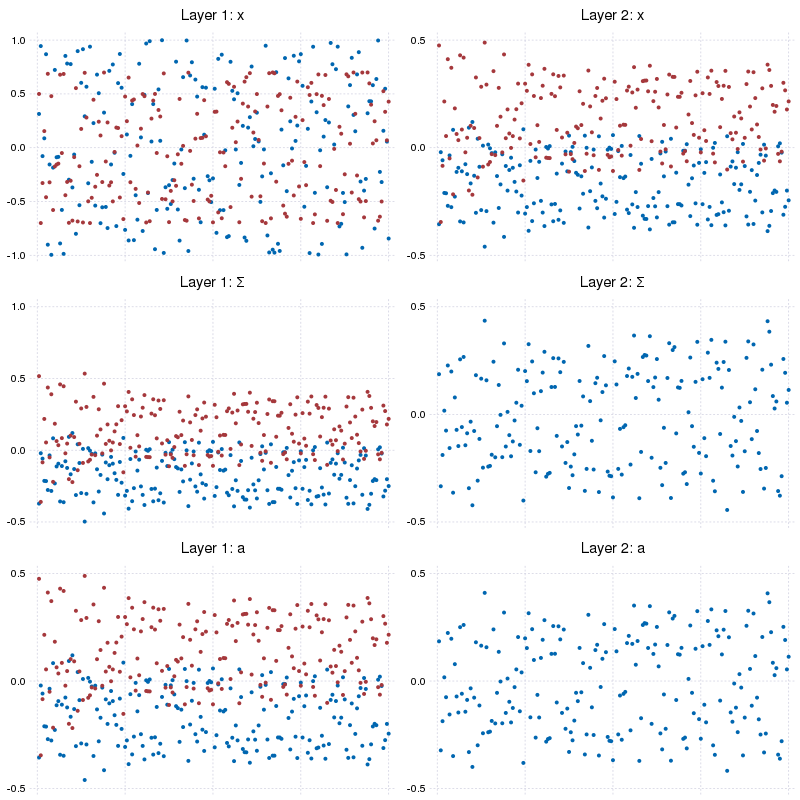

In [6]:
iterations_per_frame = 1000
total_frames = 200
dist = Distributions.Uniform(lim...)

for frm in 1:total_frames
    # pick one of the functions at random, sample from the x line, then update the
    # neural net with [x, f(x)] as the inputsn = 1000
    for i in 1:iterations_per_frame
        f = sample(funcs)
        x = rand(dist)
        y = target(f)
        update!(net, Float64[x, f(x)], [y])
    end
    
    # update the progress visualization
    update!(progressviz, true, show=false)

    # update the plot... project each series to the first hidden layer and reset the data
    # NOTE: this works because `getindex` and `setindex` are overloaded to get/set the underlying plot series data
    x = linspace(lim..., 50)
    p[1] = activateHidden(net, hcat(gridx, gridy))
    p[2] = activateHidden(net, hcat(gridy, gridx))
    p[3] = activateHidden(net, hcat(x, map(f1,x)))
    p[4] = activateHidden(net, hcat(x, map(f2,x)))

    # show/update the plot
    gui(p)
    frame(anim)
end

# displays the progress
progressviz.subplt

In [ ]:
# show stacked and linked histograms of the preditions for each class
testn = 100
xs = linspace(lim..., testn)
x1, x2 = [hcat(xs,map(f,xs)) for f in funcs]
# testx = vcat(hcat(xs,map(f1,xs)), hcat(xs,map(f2,xs)))
# testy = vcat(ones(testn), -ones(testn))
y1, y2 = ones(testn), -ones(testn)
yhat1, yhat2 = [vec(predict(net, x)) for x in (x1,x2)]
subplot(histogram(yhat1), histogram(yhat2), nc=1, linkx=true, title=["f1 prediction", "f2 prediction"], xlim=lim)

In [ ]:
plot()

In [ ]:
plot(xs, hcat(map(f1,xs), map(f2,xs), reshape(yhat,testn,2)), leg=true, w=[2 2 5 5])

# Animate!

In [ ]:
gif(anim, fps = 20)

# Network viz

In [ ]:
# show the network (uses Qwt, visualize isn't available unless you import it)
import Qwt
viz = visualize(net);

In [ ]:
# update the net representation with weights, etc
update!(viz)

# testing...

In [ ]:
selection[3][2]

In [ ]:
p[4][2] |> length

In [ ]:
gui(progressviz.subplt)

In [ ]:
using Plots
p1 = plot(rand(20))
p2 = plot(rand(10))
p3 = scatter(rand(100))
p4 = plot(rand(1000))

In [ ]:
subplot(p1,p2,p3,p4, nr=1, leg=false)

In [ ]:
immerse()
p = plot(rand(10))

In [ ]:
gui()

In [ ]:
append!(p,1,rand(10))
gui()

In [ ]:
sp = progressviz.subplt.plts[1].o.widget[:minimumSizeHint]()